<a href="https://colab.research.google.com/github/rodsei/data-science-ifes/blob/main/CIDA_Trabalho_1_Problema_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão em Séries Temporais multivariadas com LSTM (Long Short-Term Memory) no Keras

---

### Conteúdo

1. [Introdução](https://colab.research.google.com/drive/1GzBZEsKzXPYComUD2feOprKexglmQe3r#scrollTo=vLQXQ8pJ3dAD)
2. [Preparando um modelo LSTM multivarido](https://colab.research.google.com/drive/1bUTkj1qXGxhhByezJf0djTNH0AKueCx8#scrollTo=gv9CyP-HxIRi&line=1&uniqifier=1)
3. [Treinando com Múltiplos momentos anteriores](https://colab.research.google.com/drive/1bUTkj1qXGxhhByezJf0djTNH0AKueCx8#scrollTo=9EPbKKl5Y-SC)

### Referência

Jason Brownlee. Multivariate Time Series Forecasting with LSTMs in Keras. en-US. Ago. de 2017. url: https://machinelearningmastery.com/multivariate-time-series-forecasting- lstms-keras/ (acesso em 16/08/2021).

# 1. Introdução

As redees neurais LSTM são capazes de modelar problemas com várias entradas de forma exemplar, o que o torna muito vantajoso frente à vários outros modelos, uma vez que modelos lineares têm dificuldades de de adaptar a um problema de predição multivariado ou com várias entradas.


## 1.1. Base de dados

A base de dados utilizada para o exemplo será sobre a Qualidade do Ar de Beijing que mede o clima e o nível de poluição. Os dados são registrados a cada hora e foram coletados durante cinco anos na embaixada dos Estados Unidos em Beijing, China.

In [1]:
!wget 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv'

--2021-08-18 00:27:19--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2010492 (1.9M) [text/plain]
Saving to: ‘pollution.csv.3’

pollution.csv.3     100%[===================>]   1.92M  --.-KB/s    in 0.01s   

2021-08-18 00:27:20 (145 MB/s) - ‘pollution.csv.3’ saved [2010492/2010492]



In [2]:
!head -n 6 pollution.csv

No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
1,2010,1,1,0,NA,-21,-11,1021,NW,1.79,0,0
2,2010,1,1,1,NA,-21,-12,1020,NW,4.92,0,0
3,2010,1,1,2,NA,-21,-11,1019,NW,6.71,0,0
4,2010,1,1,3,NA,-21,-14,1019,NW,9.84,0,0
5,2010,1,1,4,NA,-20,-12,1018,NW,12.97,0,0


As colunas de referentes ao momento de coleta estão definidas em colunas separadas, identificano o ano, mês, dia e hora. Já a poluição é representada pela coluna pm2.5, que indica sua concentração e os demais campos são referentes ao clima, contendo nessa ordem o ponto de condensação, temperatura, pressão, direção e velocidades do vento e o total acumulado de horas com neve e chuva.

Para obter os dados e preparar a base de dados para utilização, definimos uma função que irá consolidar os campos de data em uma única coluna com o formato desejado. Esse novo campo unificado será utilizado com o Pandas como o índice da série temporal, indicando o `index_col` diretamente para o índice 0, uma vez que a nova coluna unificada não está nomeada.

In [3]:
import pandas as pd
from datetime import datetime
# load data
data_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv'
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
 
dataset = pd.read_csv(data_url, parse_dates = [['year', 'month', 'day', 'hour']], 
                   index_col=0, date_parser=parse)

In [4]:
dataset.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


Podemos visualizar alguns pontos a serem tratados logo de início antes de iniciar a construção do modelo. Vamos remover os valores nulos e as colunas que não nos interessa e por conveniência, renomear as colunas e índice da base.

In [5]:
# Removendo o número de identificação da coleta de dados
dataset.drop('No', axis=1, inplace=True)
# Definindo os nomes das colunas e índice
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

As primeiras 24 horas estão sem valores de poluição registrados. Para não influenciar o modelo, vamos tratar esses registros, transformando os valores nulos em 0 e removendo as primeiras 24 horas.

In [6]:
# Definindo os valores nulos como
dataset['pollution'].fillna(0, inplace=True)
# Remove as primeiras 24 houras, que apresentavam registros não coletados
dataset = dataset[24:]
# Exibe o estado atual da base
print(dataset.head(5))

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


## 1.2. Visualizando os dados

Por se tratar de uma série temporal com vários dados de entrada, vamos visualizar o comportamento de cada uma das colunas numéricas. 

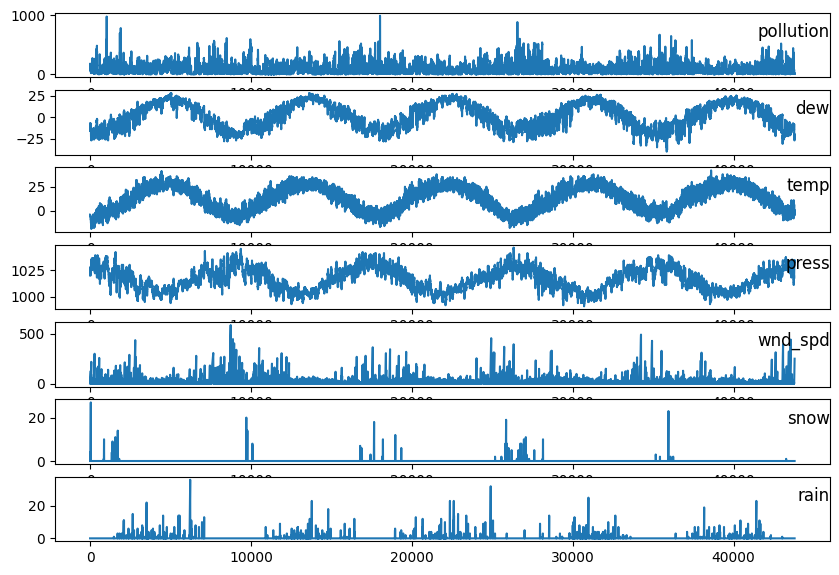

In [7]:
import matplotlib.pyplot as plt
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize=(10,7), dpi=100)
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

# 2. Preparando um modelo LSTM multivarido

Com os dados organizados vamos dar sequência à preparação dos dados específica para o modelo e criar o modelo para treinamento e validação ao fim da seção.

## 2.1. Preparando os dados

Primeiramente precisamos enquadrar os dados em um problema de aprendizado supervisionado e normalizar as variáveis de entrada. Para o primeiro passo, criamnos uma predição da poluição com base no momento imediatamente anterior. Essa opção é mais simples e atende ao pré-requisito do aprendizado supervisionado, podendo-se utilizar as últimas 24 horas por exemplo. O importante nessa etapa é que seja possível predizer o próximo valor com base nos anteriores. Com esse objetivo vamos criar a função `series_to_supervised` a seguir:

In [8]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

Antes de aplicar a função criada, vamos normalizar os dados e tratar a coluna referente à direção do vento, que é uma variável categórica, para se tornar numérica.

In [9]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

Com os dados categóricos tratados e dados numéricos normalizados, já podemos aplicar a função e transformar a base em um problema supervisionado e aplicar uma predição com os dados do momento anterior. Nesse momento, podemos remover as colunas adicionais que não serão preditas junto com o nível de poluição do momento atual.

In [10]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict: columns from the current timestamp. 
# Only pollution value matters here
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var7(t-1)  var8(t-1)   var1(t)
1   0.129779   0.352941   0.245902  ...   0.000000        0.0  0.148893
2   0.148893   0.367647   0.245902  ...   0.000000        0.0  0.159960
3   0.159960   0.426471   0.229508  ...   0.000000        0.0  0.182093
4   0.182093   0.485294   0.229508  ...   0.037037        0.0  0.138833
5   0.138833   0.485294   0.229508  ...   0.074074        0.0  0.109658

[5 rows x 9 columns]


## 2.2. Definindo o modelo

Primeiramente vamos separar a base de dados em uma amostra de treino e teste. Para exemplificar evitar um tempo alto de treinamento, serão utilizados dados apenas do primeiro ano disponível e predizer os próximos 4 anos.

Considerando um série temporal, é preciso separar os dados de treino e teste de forma sequencial. Para isso vamos calcular o total de horas que teremos em 1 ano e separar os dados com base nesse volume.

In [11]:
n_train_years = 1
# split into train and test sets
values = reframed.values
n_train_hours = 365 * n_train_years * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 8) (8760,) (35039, 8) (35039,)


Para o modelo LSTM, precisamos formatar os dados em uma estrutura 3D, como esperado pelas redes LSTM no padrão [*samples*, *timestamps*, *features*].

In [12]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


Com os dados no formato adequado já podemos iniciar a definição da rede LSTM. Para este problema, vamos utilizar 50 neurônios na primeira camada e 1 neurônio na camada de saída e para compilar no Keras, vamos utilizar a função de perda MAE (*Mean Absolute Error*) e o algoritmo de otimizacão ADAM. Os dados de entrada serão no formato de 1 instante e 8 características.

In [13]:
from keras import models, layers

# design network
model = models.Sequential()
model.add(layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(1))
model.compile(loss='mae', optimizer='adam')

Com a rede neural definida e compilada, já podemos realizar o treinamento do modelo e visualizar os dados de treino.

In [14]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                    validation_data=(test_X, test_y), verbose=0, shuffle=False)

Com o modelo pronto e treinado conseguimos visualizar os dados de treino:

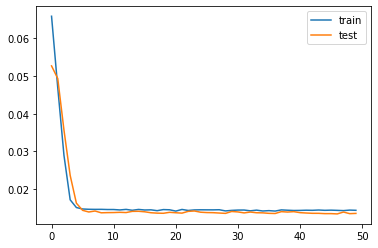

In [15]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 2.3. Avaliando o modelo

Já estamos com tudo preparado para realizar as predições do restante da base e avaliar o desempenho do modelo que foi criado.

In [16]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

Com as predições realizadas, precisamos reverter a escala que adotamos para que seja possível comparar com os dados originais e obtermos as métricas de avaliação. O `MinMaxScaler` possui uma função que inverte a escala adotada previamente. Vamos utilizá-la a seguir:

In [17]:
import numpy as np

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

Após inverter a escala aplicada nas predições e na base original, podemos calcular o RMSE: 

In [18]:
from math import sqrt
from sklearn.metrics import mean_squared_error

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.632


# 3. Treinando com Múltiplos momentos anteriores

As diferenças para realizar o treinamento do modelo de predição utilizando vários deslocamentos anteriores são muito pequenas. Precisamos estar atentos apenas a alguns detalhes. Para o exemplo, vamos utilizar 3 horas prévias como entrada. 


In [19]:
# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
multilag_reframed = series_to_supervised(scaled, n_hours, 1)
multilag_reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
3,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0
6,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0,0.105634,0.485294,0.213115,0.581818,0.666667,0.014492,0.148148,0.0
7,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0,0.105634,0.485294,0.213115,0.581818,0.666667,0.014492,0.148148,0.0,0.124748,0.485294,0.229508,0.600000,0.666667,0.017551,0.000000,0.0


Neste caso não vamos precisar remover as colunas de todos os campos do momento que vamos prever. Sendo assim, considerando que temos $3*8+8$ colunas nessa nova abordagem, para definir as colunas de entrada e saída vamos utilizar as primeiras 24 colunas como observações de entrada referentes à 8 características das últimas 3 horas e apenas a última coluna representando o nível de poluição que queremos predizer. 

In [49]:
# split into train and test sets
values = multilag_reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(8760, 24) 8760 (8760,)


Com as colunas das características selecionadas, vamos formatar os dados para satisfazer o padrão esperado pelo modelo:

In [52]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)


A definição do modelo não muda, podemos realizar o mesmo processo:

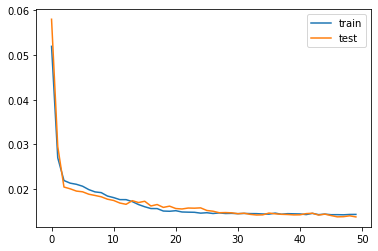

In [55]:
# design network
model = models.Sequential()
model.add(layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Nesse novo formato com 8 colunas de cada momento anterior, precisamos levar em consideração a forma de avaliar o modelo. Basicamente o ponto de atenção é em relação aos dados de entrada que possuem 7 características.

In [64]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

Após realizar a inversão da escala nos dados de teste e treino nesse novo formato, já podemos avaliar o modelo corretamente.

In [65]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.367


Com essa avaliação notamos que não obtivemos nenhum benefício utilizando mais momentos, só aumentou a complexidade para lidar com os dados de treino e com as transformações.